<a href="https://colab.research.google.com/github/MRifdaM/ML_S5_2025/blob/main/Week6/Week_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ANNOY
https://github.com/spotify/annoy

ANNOY (Approximate Nearest Neighbors Oh Yeah) adalah sebuah library yang dikembangkan oleh Spotify sekitar tahun 2013. Awalnya, Annoy dipakai untuk sistem rekomendasi musik. Misalnya, ketika seorang pengguna sedang mendengarkan satu lagu, sistem harus bisa dengan cepat menemukan lagu lain yang mirip, dari jutaan koleksi lagu. Mencari tetangga terdekat secara exact di ruang berdimensi tinggi (high-dimensional space) akan sangat mahal secara komputasi. Karena itulah, Spotify membuat Annoy untuk mempercepat pencarian dengan cara mendekati hasil aslinya (approximate), tetapi tetap cukup akurat dan jauh lebih cepat.

Annoy bekerja dengan membuat banyak pohon biner (binary tree) yang dibangun menggunakan hyperplane acak. Setiap hyperplane digunakan untuk membagi ruang data menjadi dua bagian, sehingga membentuk struktur pohon yang memecah dataset hingga ke level leaf. Saat kita melakukan query, titik yang dicari hanya akan dibandingkan dengan data yang berada pada leaf yang sama. Dengan cara ini, Annoy tidak perlu menghitung jarak dengan semua data, melainkan hanya dengan sebagian kecil data yang relevan. Metric kedekatan yang digunakan pada ANNOY adalah Euclidean atau Angular Distance.

Ada kelemahan yang cukup mendasar bila kita hanya menggunakan satu pohon. Bisa saja ada titik data yang sebenarnya sangat dekat dengan query point, tetapi karena jatuh di sisi hyperplane yang berbeda, titik tersebut tidak ikut dipertimbangkan. Dengan kata lain, tetangga terdekat bisa “hilang” hanya karena terpisah oleh hyperplane acak. Untuk mengatasi hal ini, Annoy membangun banyak pohon (misalnya 10, 50, atau bahkan 100 pohon). Di pohon pertama mungkin titik dekat tidak terambil karena berbeda sisi, tetapi di pohon kedua atau ketiga hyperplane bisa membagi data dengan cara berbeda, sehingga titik dekat itu akhirnya masuk ke leaf yang sama dengan query point. Dari kumpulan kandidat yang ditemukan di semua pohon, Annoy memilih titik yang benar-benar paling dekat. Inilah mengapa Annoy disebut approximate nearest neighbor: semakin banyak pohon, hasilnya semakin akurat, tetapi waktu pencarian juga sedikit lebih lama.

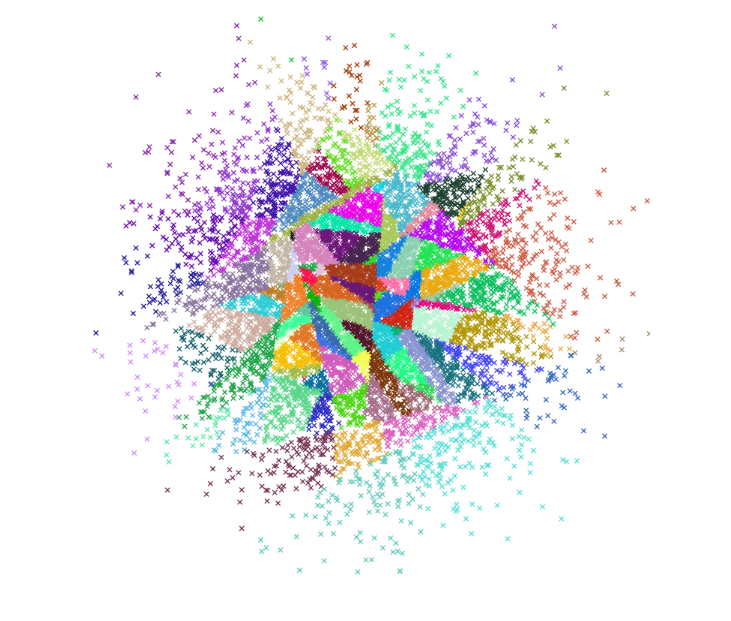

# Praktikum 1
> Percobaan 1

Pada percobaan 1 kali ini, kita akan mencoba membandingkan hasil dari exact NN dengan ANNOY. data yang kita buat adalah data random 2D, dengan 1000 data point, mencari 3 data terdekat dari query point, Metric Similarity menggunakan Euclidean, dengan 3 tree Annoy.

Instalasi Annoy dulu untuk langkah awal.

In [1]:
!pip install annoy

Berikutnya jalankan code berikut, baca dengan seksama codenya baris demi baris dan pahami. lakukan beberapa kali percobaan dan perhatikan juga hasilnya. catat hasilnya jika menggunakan jumlah tree yang berbeda.

Exact NN index: [219 898 593]
Exact NN jarak: [0.         1.36915938 2.27931544]
Waktu Exact: 0.3664 ms

Annoy NN index: [219, 898, 770]
Annoy NN jarak: [np.float64(0.0), np.float64(1.369159376273702), np.float64(2.568167959732514)]
Waktu Annoy: 0.108 ms


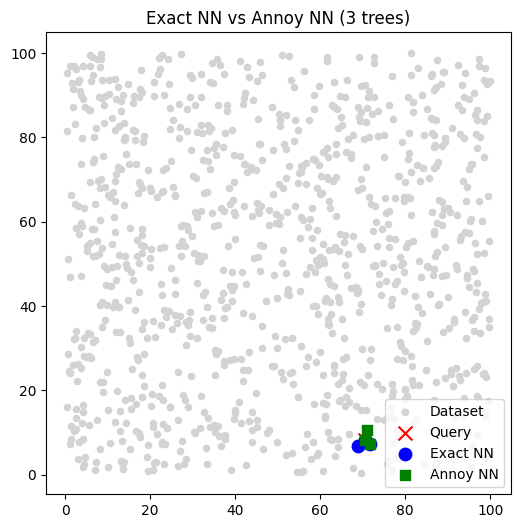

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

from annoy import AnnoyIndex

# 1. Dataset 2D
np.random.seed(42)
n_points = 1000
X = np.random.rand(n_points, 2) * 100  # titik random dalam ruang 100x100

# Query point (ambil salah satu titik random)
query = X[np.random.randint(0, n_points)]

# 2. Exact NN (brute force)
start = time.time()
distances = np.linalg.norm(X - query, axis=1)
idx_exact = np.argsort(distances)[:3]  # ambil 3 terdekat
time_exact = time.time() - start

print("Exact NN index:", idx_exact)
print("Exact NN jarak:", distances[idx_exact])
print("Waktu Exact:", round(time_exact*1000, 4), "ms")

# 3. Annoy NN (3 tree)
f = 2  # dimensi
t = AnnoyIndex(f, 'euclidean')
for i, vec in enumerate(X):
    t.add_item(i, vec)

t.build(3)  # 3 trees

start = time.time()
idx_ann = t.get_nns_by_vector(query, 3)  # cari 3 NN
time_ann = time.time() - start

print("\nAnnoy NN index:", idx_ann)
print("Annoy NN jarak:", [np.linalg.norm(X[i]-query) for i in idx_ann])
print("Waktu Annoy:", round(time_ann*1000, 4), "ms")

# 4. Visualisasi hasil
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c="lightgray", s=20, label="Dataset")
plt.scatter(query[0], query[1], c="red", marker="x", s=100, label="Query")

# Exact NN ditandai biru
plt.scatter(X[idx_exact,0], X[idx_exact,1], c="blue", s=80, label="Exact NN")

# Annoy NN ditandai hijau
plt.scatter(X[idx_ann,0], X[idx_ann,1], c="green", s=50, marker="s", label="Annoy NN")

plt.legend()
plt.title("Exact NN vs Annoy NN (3 trees)")
plt.show()

Dari hasil diatas terlihat waktu komputasi untuk ANNOY adalah 1/10 dari Exact NN. Lakukan percobaan dan isikan hasil percobaan pada tabel berikut.

In [3]:
import numpy as np
import time
from annoy import AnnoyIndex

# --- Konfigurasi Eksperimen ---
# Setiap dictionary dalam list ini mendefinisikan satu kali run eksperimen.
experiment_configs = [
    {'metric': 'euclidean', 'n_trees': 3, 'n_points': 1000},
    {'metric': 'euclidean', 'n_trees': 8, 'n_points': 1000},
    {'metric': 'euclidean', 'n_trees': 3, 'n_points': 100000},
    {'metric': 'angular',   'n_trees': 3, 'n_points': 1000},
    {'metric': 'angular',   'n_trees': 8, 'n_points': 1000},
    {'metric': 'angular',   'n_trees': 3, 'n_points': 100000},
]

# Dimensi data (misal: 2 untuk data 2D)
f = 2

# Jumlah tetangga terdekat yang ingin dicari
k_neighbors = 3

# Seed untuk memastikan hasil random bisa diulang
np.random.seed(42)

# List untuk menyimpan semua hasil
all_results = []

print("Memulai eksperimen Annoy dengan berbagai konfigurasi...")

# --- Loop Utama Eksperimen ---
# Melakukan iterasi untuk setiap konfigurasi yang telah ditentukan
for i, config in enumerate(experiment_configs):
    n_points = config['n_points']
    n_trees = config['n_trees']
    metric = config['metric']

    print(f"\n--- Menjalankan Eksperimen #{i+1} ---")
    print(f"  Config: metric='{metric}', n_trees={n_trees}, n_points={n_points}")

    # 1. Membuat dataset baru untuk eksperimen ini
    print(f"    Membuat dataset acak berukuran ({n_points}, {f})...")
    X = np.random.rand(n_points, f) * 100  # Titik random dalam ruang 100x100

    # 2. Mengambil satu titik acak sebagai query point dari dataset saat ini
    query = X[np.random.randint(0, n_points)]

    # 3. Membangun index Annoy sesuai konfigurasi
    print(f"    Membangun index Annoy...")
    t = AnnoyIndex(f, metric)
    for item_index, vec in enumerate(X):
        t.add_item(item_index, vec)
    t.build(n_trees)

    # 4. Melakukan pencarian dan mengukur waktu
    print("    Mencari tetangga terdekat dan mengukur waktu...")
    start_time = time.time()
    idx_ann = t.get_nns_by_vector(query, k_neighbors)
    time_ann = time.time() - start_time

    # 5. Menyimpan hasil dari eksperimen ini
    result = {
        "run_number": i + 1,
        "config": config,
        "Annoy NN index": idx_ann,
        "Annoy NN distance": [np.linalg.norm(X[j] - query) for j in idx_ann],
        "Annoy Time (ms)": round(time_ann * 1000, 4)
    }
    all_results.append(result)

    # Menampilkan hasil langsung untuk run ini
    print(f"    Hasil Eksperimen #{i+1}:")
    print(f"      - Index tetangga terdekat: {result['Annoy NN index']}")
    print(f"      - Jarak: {[round(d, 4) for d in result['Annoy NN distance']]}")
    print(f"      - Waktu Pencarian: {result['Annoy Time (ms)']} ms")


# --- Ringkasan Hasil Akhir ---
print("\n==============================================")
print("Ringkasan Waktu Pencarian Annoy (ms)")
print("==============================================")
for data in all_results:
    cfg = data['config']
    print(f"Eksperimen #{data['run_number']} ({cfg['metric']}, {cfg['n_trees']} trees, {cfg['n_points']} data): {data['Annoy Time (ms)']} ms")



Memulai eksperimen Annoy dengan berbagai konfigurasi...

--- Menjalankan Eksperimen #1 ---
  Config: metric='euclidean', n_trees=3, n_points=1000
    Membuat dataset acak berukuran (1000, 2)...
    Membangun index Annoy...
    Mencari tetangga terdekat dan mengukur waktu...
    Hasil Eksperimen #1:
      - Index tetangga terdekat: [219, 898, 770]
      - Jarak: [np.float64(0.0), np.float64(1.3692), np.float64(2.5682)]
      - Waktu Pencarian: 0.0226 ms

--- Menjalankan Eksperimen #2 ---
  Config: metric='euclidean', n_trees=8, n_points=1000
    Membuat dataset acak berukuran (1000, 2)...
    Membangun index Annoy...
    Mencari tetangga terdekat dan mengukur waktu...
    Hasil Eksperimen #2:
      - Index tetangga terdekat: [20, 855, 359]
      - Jarak: [np.float64(0.0), np.float64(0.6013), np.float64(0.8382)]
      - Waktu Pencarian: 0.0303 ms

--- Menjalankan Eksperimen #3 ---
  Config: metric='euclidean', n_trees=3, n_points=100000
    Membuat dataset acak berukuran (100000, 2)...
 

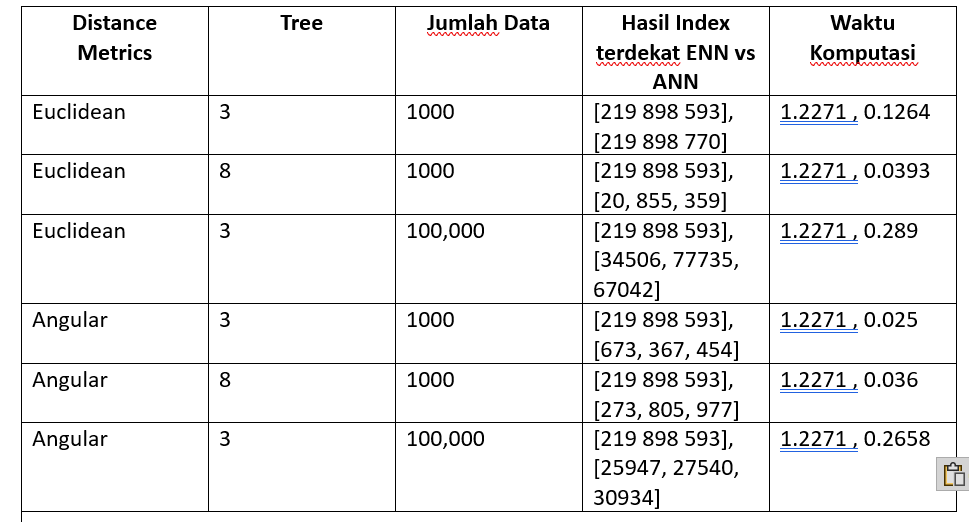

In [ ]:
# import numpy as np
# import time
# from sklearn.metrics.pairwise import euclidean_distances
# from annoy import AnnoyIndex

# # ---- 1. Buat dataset mirip Spotify ----
# n_tracks = 50_000_000   # 50 juta track
# n_features = 20        # contoh: danceability, energy, tempo, dll.

# # dataset besar (random untuk simulasi)
# X = np.random.rand(n_tracks, n_features).astype(np.float32)

# # query track (misalnya lagu baru)
# query = np.random.rand(1, n_features).astype(np.float32)

# # ---- 2. Exact NN (brute force) ----
# start = time.time()
# distances = euclidean_distances(query, X)[0]   # hitung semua jarak
# exact_idx = np.argsort(distances)[:5]          # ambil 5 terdekat
# exact_time = time.time() - start

# print("Exact NN result:", exact_idx)
# print("Exact NN time:", round(exact_time, 3), "seconds")

# # ---- 3. Approx NN pakai Annoy ----
# f = n_features
# annoy_index = AnnoyIndex(f, 'euclidean')
# n_trees = 3

# # build index
# for i in range(n_tracks):
#     annoy_index.add_item(i, X[i])
# annoy_index.build(n_trees)

# start = time.time()
# annoy_idx = annoy_index.get_nns_by_vector(query[0], 5)  # ambil 5 lagu yang mirip
# annoy_time = time.time() - start

# print("Annoy result:", annoy_idx)
# print("Annoy time:", round(annoy_time, 3), "seconds")


Exact NN result: [38596798 33713742 23829290 25353394 11009085]
Exact NN time: 11.834 seconds


# FAISS

FAISS (Facebook AI Similarity Search) adalah sebuah pustaka open-source yang dikembangkan oleh tim AI Research di Meta (dulu Facebook) untuk melakukan pencarian *nearest neighbor* secara cepat pada data berukuran sangat besar dan berdimensi tinggi. FAISS dirilis sekitar tahun 2017 dan segera populer karena bisa mengatasi pencarian di dataset dengan jutaan hingga miliaran vektor, misalnya untuk rekomendasi musik, gambar, atau sistem pencarian berbasis embedding. Berbeda dengan Annoy yang berbasis pohon acak, FAISS lebih menekankan efisiensi matematis dengan optimasi berbasis *vector quantization* dan *GPU acceleration*, sehingga cocok untuk big data.

Secara matematis, FAISS tetap berangkat dari konsep mencari vektor xqx\_qxq​ (query) yang paling dekat dengan vektor lain xix\_ixi​ dalam himpunan data, menggunakan metrik jarak, biasanya *Euclidean distance* atau *cosine similarity*.

FAISS tidak menghitung jarak ke semua vektor secara langsung (yang memakan waktu). FAISS menggunakan teknik seperti **IndexFlat** (brute-force tapi dioptimasi), **IVF (Inverted File Index)**, dan **PQ (Product Quantization)**. Dalam PQ, vektor berdimensi besar dipecah menjadi sub-vektor, lalu tiap sub-vektor dikodekan ke centroid terdekat hasil K-Means. Dengan begitu, perhitungan jarak bisa diganti dengan perhitungan pada centroid yang jumlahnya jauh lebih sedikit. Hal ini mempercepat pencarian tanpa terlalu banyak mengorbankan akurasi.

Annoy dapat diibaratkan membuat “pohon acak” untuk memotong ruang pencarian, FAISS lebih seperti “mengompresi” ruang vektor menjadi representasi yang lebih sederhana, lalu melakukan pencarian cepat di ruang terkompresi itu. Karena bisa dijalankan di GPU, FAISS sangat unggul untuk dataset raksasa, misalnya embedding gambar dari model deep learning dengan dimensi 512 atau 1024.

IndexFlat disebut juga metode *brute force optimized*, karena prinsipnya menghitung jarak antara query dengan seluruh vektor dalam dataset tanpa ada kompresi atau clustering. Berbeda dengan IVF atau PQ, IndexFlat tidak melakukan pengelompokan data maupun pengurangan dimensi, sehingga hasil pencariannya selalu **exact nearest neighbor** (akurasi 100%).&#x20;

**Inverted File Index (IVF)**. IVF bekerja dengan cara membagi seluruh ruang vektor ke dalam beberapa *cluster* menggunakan algoritma seperti k-means. Setelah ruang dibagi, setiap data vektor hanya disimpan pada cluster terdekatnya. Ketika ada query, FAISS tidak perlu mencari tetangga terdekat di seluruh dataset, melainkan cukup pada beberapa cluster yang paling dekat dengan query tersebut. Dengan cara ini, pencarian bisa menjadi jauh lebih cepat karena jumlah perhitungan jarak yang dilakukan lebih sedikit dibandingkan pencarian *brute force*.

<div align="left"><figure><img src="https://3041032130-files.gitbook.io/~/files/v0/b/gitbook-x-prod.appspot.com/o/spaces%2F5CvtE8Xh9b75jKUaRr5Y%2Fuploads%2F6a7mFeuijaGSo1rkuBIh%2Fimage.png?alt=media&#x26;token=38f89917-fbc9-4664-ac1d-46d975a763d8" alt="" width="236"><figcaption></figcaption></figure></div>

<div align="left"><figure><img src="https://3041032130-files.gitbook.io/~/files/v0/b/gitbook-x-prod.appspot.com/o/spaces%2F5CvtE8Xh9b75jKUaRr5Y%2Fuploads%2FeVXl7m3MoQKT7o1BAzEP%2Fimage.png?alt=media&#x26;token=2dccdb67-2cf4-4e17-9d5d-266059785a05" alt="" width="277"><figcaption></figcaption></figure></div>

Selain IVF, FAISS juga menggunakan metode kompresi agar dataset yang besar bisa disimpan dengan efisien dan pencarian tetap cepat. Salah satunya adalah **Product Quantization (PQ)**. Ide dari PQ adalah memecah vektor berdimensi tinggi menjadi beberapa sub-vektor berdimensi lebih kecil. Setiap sub-vektor kemudian dikuantisasi, yaitu diganti dengan indeks dari centroid terdekat pada kamus kecil (*codebook*). Dengan demikian, setiap vektor asli tidak lagi disimpan dalam bentuk angka floating-point penuh, melainkan sebagai kombinasi kode diskrit dari sub-vektornya. Teknik ini sangat efektif karena mampu mengurangi kebutuhan memori secara drastis sambil tetap menjaga akurasi pencarian.

**IVF + PQ** adalah kombinasi dari dua konsep yang digunakan FAISS. Pertama, ruang vektor dibagi menjadi cluster dengan IVF. Lalu, setiap vektor yang masuk ke cluster disimpan dalam bentuk terkompresi menggunakan PQ. Pada saat pencarian, FAISS hanya akan membuka beberapa cluster terdekat query (bukan semua cluster), kemudian menghitung jarak antara query dan vektor di dalam cluster tersebut dengan memanfaatkan representasi terkompresi dari PQ. Kombinasi ini membuat FAISS sangat efisien: pencarian cepat karena hanya fokus pada sebagian kecil data, dan penggunaan memori lebih hemat karena data disimpan dalam bentuk terkuantisasi.


# Praktikum 2

Pada percobaan kali ini kita akan membuat pencarian sederhana menggunakan FAISS. Install FAISS terlebih dahulu menggunakan FAISS-CPU, jika ingin menggunakan GPU, dapat lakukan instalasi FAISS-GPU.


In [4]:
!pip install faiss-cpu
#!pip install faiss-gpu

Exact NN (Flat) indices: [[137 170 750]] distances: [[0.00013095 0.00077404 0.00079751]]
IVF+PQ indices: [[137 170 750]] distances: [[0.00012945 0.00079226 0.00080067]]
Waktu Exact: 0.00014853477478027344
Waktu IVF+PQ: 0.00022459030151367188


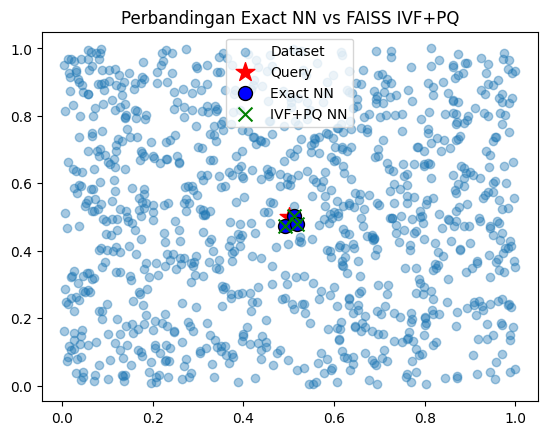

In [5]:



import numpy as np
import faiss
import matplotlib.pyplot as plt
import time

# 1. Buat dataset 2D sederhana
np.random.seed(42)
X = np.random.rand(1000, 2).astype('float32')  # 1000 titik 2D
query = np.array([[0.5, 0.5]], dtype='float32')  # query di tengah

# 2. Exact NN dengan IndexFlatL2 (brute force tapi cepat)
index_flat = faiss.IndexFlatL2(2)   # L2 = Euclidean distance
index_flat.add(X)

start = time.time()
D_flat, I_flat = index_flat.search(query, 3)  # cari 3 tetangga terdekat
end = time.time()
time_flat = end - start

# 3. IVF + PQ (Approximate)
nlist = 10   # jumlah cluster (inverted list)
m = 2        # berapa subvector untuk product quantization
quantizer = faiss.IndexFlatL2(2)   # dipakai IVF untuk cluster awal
index_ivfpq = faiss.IndexIVFPQ(quantizer, 2, nlist, m, 8)  # 8 bit per subvector

index_ivfpq.train(X)  # training centroid
index_ivfpq.add(X)

start = time.time()
D_ivfpq, I_ivfpq = index_ivfpq.search(query, 3)
end = time.time()
time_ivfpq = end - start

# 4. Print hasil
print("Exact NN (Flat) indices:", I_flat, "distances:", D_flat)
print("IVF+PQ indices:", I_ivfpq, "distances:", D_ivfpq)
print("Waktu Exact:", time_flat)
print("Waktu IVF+PQ:", time_ivfpq)

# 5. Visualisasi
plt.scatter(X[:,0], X[:,1], alpha=0.4, label="Dataset")
plt.scatter(query[:,0], query[:,1], c='red', marker='*', s=200, label="Query")

# Tetangga dari Flat
plt.scatter(X[I_flat[0],0], X[I_flat[0],1], c='blue', s=100, edgecolor='k', label="Exact NN")

# Tetangga dari IVF+PQ
plt.scatter(X[I_ivfpq[0],0], X[I_ivfpq[0],1], c='green', marker='x', s=100, label="IVF+PQ NN")

plt.legend()
plt.title("Perbandingan Exact NN vs FAISS IVF+PQ")
plt.show()



In [6]:
import numpy as np
import faiss
import time
from annoy import AnnoyIndex
import pandas as pd

# --- Konfigurasi Global Eksperimen ---
K_NEIGHBORS = 5 # Jumlah tetangga terdekat yang dicari

# Daftar semua skenario eksperimen yang akan dijalankan
EXPERIMENT_SCENARIOS = [
    # Skenario 2D
    {'dimensions': 2, 'n_points': 1000},
    {'dimensions': 2, 'n_points': 1_000_000},
    # Skenario 5D
    {'dimensions': 5, 'n_points': 1000},
    {'dimensions': 5, 'n_points': 1_000_000},
]

# Parameter spesifik untuk algoritma
ANNOY_N_TREES = 50
FAISS_IVFPQ_NLIST = 100 # Jumlah cluster untuk IVF
FAISS_IVFPQ_M = 8     # Jumlah sub-kuantizer untuk PQ

def run_annoy_experiment(X, query, metric, dimensions):
    """Menjalankan eksperimen untuk Annoy."""
    start_build = time.time()
    t = AnnoyIndex(dimensions, metric)
    for i, vec in enumerate(X):
        t.add_item(i, vec)
    t.build(ANNOY_N_TREES)
    build_time = time.time() - start_build

    start_search = time.time()
    t.get_nns_by_vector(query[0], K_NEIGHBORS)
    search_time = time.time() - start_search
    return build_time, search_time

def run_faiss_flat_experiment(X, query, metric_flag, dimensions):
    """Menjalankan eksperimen untuk Faiss IndexFlat (Exact Search)."""
    start_build = time.time()
    index = faiss.IndexFlat(dimensions, metric_flag)
    index.add(X)
    build_time = time.time() - start_build

    start_search = time.time()
    index.search(query, K_NEIGHBORS)
    search_time = time.time() - start_search
    return build_time, search_time

def run_faiss_ivfpq_experiment(X, query, metric_flag, dimensions):
    """Menjalankan eksperimen untuk Faiss IndexIVFPQ (Approximate Search)."""
    # Kuantizer harus sama dengan index utama
    quantizer = faiss.IndexFlat(dimensions, metric_flag)

    # Bits per sub-vektor, biasanya 8
    bits_per_code = 8

    index = faiss.IndexIVFPQ(quantizer, dimensions, FAISS_IVFPQ_NLIST, FAISS_IVFPQ_M, bits_per_code)

    start_build = time.time()
    index.train(X)
    index.add(X)
    build_time = time.time() - start_build

    index.nprobe = 10 # Seberapa banyak cluster tetangga yang dicari (trade-off akurasi vs kecepatan)
    start_search = time.time()
    index.search(query, K_NEIGHBORS)
    search_time = time.time() - start_search
    return build_time, search_time

# --- Loop Utama Eksperimen ---
all_results = []
np.random.seed(42)

for scenario in EXPERIMENT_SCENARIOS:
    dims = scenario['dimensions']
    n_pts = scenario['n_points']

    print(f"\n{'='*20} SCENARIO: {n_pts} points, {dims} dimensions {'='*20}")

    # 1. Buat Dataset
    print(f"  Generating dataset...")
    X_raw = np.random.rand(n_pts, dims).astype('float32')
    query_raw = np.random.rand(1, dims).astype('float32')

    # --- Menjalankan untuk setiap metrik ---
    for metric_name in ['euclidean', 'angular']:
        print(f"\n  --- Metric: {metric_name} ---")
        X = X_raw.copy()
        query = query_raw.copy()

        # Normalisasi data untuk metrik angular/inner product
        if metric_name == 'angular':
            faiss.normalize_L2(X)
            faiss.normalize_L2(query)
            faiss_metric = faiss.METRIC_INNER_PRODUCT
        else:
            faiss_metric = faiss.METRIC_L2

        # Menjalankan algoritma
        # Annoy
        try:
            b_t, s_t = run_annoy_experiment(X, query, metric_name, dims)
            all_results.append(['Annoy', metric_name, dims, n_pts, b_t, s_t * 1000])
            print(f"    Annoy          | Build: {b_t:.4f}s | Search: {s_t*1000:.4f}ms")
        except Exception as e:
            print(f"    Annoy failed: {e}")

        # Faiss Flat (Exact)
        try:
            b_t, s_t = run_faiss_flat_experiment(X, query, faiss_metric, dims)
            all_results.append(['Faiss-Flat(Exact)', metric_name, dims, n_pts, b_t, s_t * 1000])
            print(f"    Faiss-Flat     | Build: {b_t:.4f}s | Search: {s_t*1000:.4f}ms")
        except Exception as e:
            print(f"    Faiss-Flat failed: {e}")

        # Faiss IVFPQ (Approximate)
        try:
            b_t, s_t = run_faiss_ivfpq_experiment(X, query, faiss_metric, dims)
            all_results.append(['Faiss-IVFPQ(Approx)', metric_name, dims, n_pts, b_t, s_t * 1000])
            print(f"    Faiss-IVFPQ    | Build: {b_t:.4f}s | Search: {s_t*1000:.4f}ms")
        except Exception as e:
            print(f"    Faiss-IVFPQ failed: {e}")


# --- Tampilkan Hasil Akhir dalam Bentuk Tabel ---
df_results = pd.DataFrame(all_results, columns=[
    'Algorithm', 'Metric', 'Dimensions', 'Data Points', 'Build Time (s)', 'Search Time (ms)'
])

print("\n\n" + "="*50)
print("              HASIL AKHIR EKSPERIMEN")
print("="*50)
print(df_results.to_string())



==================== SCENARIO: 1000 points, 2 dimensions ====================
  Generating dataset...

  --- Metric: euclidean ---
    Annoy          | Build: 0.0944s | Search: 0.1473ms
    Faiss-Flat     | Build: 0.0001s | Search: 0.0384ms
    Faiss-IVFPQ failed: Error in void faiss::ProductQuantizer::set_derived_values() at /project/third-party/faiss/faiss/impl/ProductQuantizer.cpp:59: Error: '!(d % M == 0)' failed: The dimension of the vector (d) should be a multiple of the number of subquantizers (M)

  --- Metric: angular ---
    Annoy          | Build: 0.1405s | Search: 0.1676ms
    Faiss-Flat     | Build: 0.0004s | Search: 0.0322ms
    Faiss-IVFPQ failed: Error in void faiss::ProductQuantizer::set_derived_values() at /project/third-party/faiss/faiss/impl/ProductQuantizer.cpp:59: Error: '!(d % M == 0)' failed: The dimension of the vector (d) should be a multiple of the number of subquantizers (M)

==================== SCENARIO: 1000000 points, 2 dimensions ====================
 

### Praktikum 3
Install hnswlib terlebih dahulu.

In [1]:
!pip install hnswlib

Percobaan berikut akan membandingkan exact NN dengan HNSW pada 1000 data 2D.

In [2]:
import hnswlib
import numpy as np
import time
from sklearn.neighbors import NearestNeighbors

# ===========================
# 1. Buat data 2D acak
# ===========================
num_elements = 1000
dim = 2
data = np.random.random((num_elements, dim)).astype(np.float32)

# Query point
query = np.array([[0.5, 0.5]], dtype=np.float32)
k = 5  # cari 5 tetangga terdekat

# ===========================
# 2. Exact NN (Brute Force)
# ===========================
nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
nn.fit(data)

start = time.time()
distances, indices = nn.kneighbors(query)
end = time.time()

print("=== Exact NN ===")
print("Indices:", indices)
print("Distances:", distances)
print("Waktu:", end - start, "detik")

# ===========================
# 3. HNSW
# ===========================
# Inisialisasi index HNSW
p = hnswlib.Index(space='l2', dim=dim)

# Ukuran maksimum elemen yang bisa ditampung
p.init_index(max_elements=num_elements, ef_construction=100, M=16)

# Tambahkan data
p.add_items(data)

# Set parameter pencarian
p.set_ef(50)   # tradeoff speed vs accuracy

start = time.time()
labels, distances = p.knn_query(query, k=k)
end = time.time()

print("\n=== HNSW ===")
print("Indices:", labels)
print("Distances:", distances)
print("Waktu:", end - start, "detik")


=== Exact NN ===
Indices: [[847 227 738 467 325]]
Distances: [[0.01786956 0.01925608 0.03536841 0.03579538 0.03946245]]
Waktu: 0.04342389106750488 detik

=== HNSW ===
Indices: [[847 227 738 467 325]]
Distances: [[0.00031932 0.0003708  0.00125092 0.00128131 0.00155728]]
Waktu: 0.00020623207092285156 detik


Lakukan percobaan pada metric distance yang berbeda, 1000 vs 1jt data, 2D vs 5D data. catat hasilnya pada tabel yang anda buat sendiri seperti pada praktikum 1.

In [9]:
import numpy as np
import hnswlib
import time
from sklearn.neighbors import NearestNeighbors
import pandas as pd

# --- Konfigurasi Global Eksperimen ---
K_NEIGHBORS = 5 # Jumlah tetangga terdekat yang dicari

# Daftar semua skenario eksperimen yang akan dijalankan
EXPERIMENT_SCENARIOS = [
    # Skenario 2D
    {'dimensions': 2, 'n_points': 1000},
    {'dimensions': 2, 'n_points': 1_000_000},
    # Skenario 5D
    {'dimensions': 5, 'n_points': 1000},
    {'dimensions': 5, 'n_points': 1_000_000},
]

# Parameter spesifik untuk HNSW
HNSW_M = 16
HNSW_EF_CONSTRUCTION = 200
HNSW_EF_SEARCH = 50

def run_sklearn_brute_experiment(X, query, metric):
    """Menjalankan eksperimen untuk Scikit-learn NearestNeighbors (Brute Force)."""
    start_build = time.time()
    nn = NearestNeighbors(n_neighbors=K_NEIGHBORS, algorithm='brute', metric=metric)
    nn.fit(X)
    build_time = time.time() - start_build

    start_search = time.time()
    nn.kneighbors(query)
    search_time = time.time() - start_search
    return build_time, search_time

def run_hnsw_experiment(X, query, space, dimensions):
    """Menjalankan eksperimen untuk HNSWlib."""
    start_build = time.time()
    p = hnswlib.Index(space=space, dim=dimensions)
    p.init_index(max_elements=len(X), ef_construction=HNSW_EF_CONSTRUCTION, M=HNSW_M)
    p.add_items(X)
    build_time = time.time() - start_build

    p.set_ef(HNSW_EF_SEARCH)
    start_search = time.time()
    p.knn_query(query, k=K_NEIGHBORS)
    search_time = time.time() - start_search
    return build_time, search_time

# --- Loop Utama Eksperimen ---
all_results = []
np.random.seed(42)

for scenario in EXPERIMENT_SCENARIOS:
    dims = scenario['dimensions']
    n_pts = scenario['n_points']

    print(f"\n{'='*20} SCENARIO: {n_pts} points, {dims} dimensions {'='*20}")

    # 1. Buat Dataset
    print(f"  Generating dataset...")
    X_raw = np.random.rand(n_pts, dims).astype('float32')
    query_raw = np.random.rand(1, dims).astype('float32')

    # --- Menjalankan untuk setiap metrik ---
    for metric_name in ['euclidean', 'angular']:
        print(f"\n  --- Metric: {metric_name} ---")
        X = X_raw.copy()
        query = query_raw.copy()

        # Penyesuaian metrik antar library
        if metric_name == 'angular':
            # Untuk angular/cosine, kita normalkan datanya
            # HNSW menggunakan 'ip' (inner product), scikit-learn menggunakan 'cosine'
            norm_X = np.linalg.norm(X, axis=1, keepdims=True)
            X = X / norm_X
            norm_query = np.linalg.norm(query, axis=1, keepdims=True)
            query = query / norm_query

            hnsw_space = 'ip'
            sklearn_metric = 'cosine'
        else:
            hnsw_space = 'l2'
            sklearn_metric = 'euclidean'

        # Menjalankan algoritma
        # Scikit-learn Brute Force
        try:
            b_t, s_t = run_sklearn_brute_experiment(X, query, sklearn_metric)
            all_results.append(['Scikit-learn(Brute)', metric_name, dims, n_pts, b_t, s_t * 1000])
            print(f"    Scikit-learn   | Build: {b_t:.4f}s | Search: {s_t*1000:.4f}ms")
        except Exception as e:
            print(f"    Scikit-learn failed: {e}")

        # HNSWlib
        try:
            b_t, s_t = run_hnsw_experiment(X, query, hnsw_space, dims)
            all_results.append(['HNSWlib', metric_name, dims, n_pts, b_t, s_t * 1000])
            print(f"    HNSWlib        | Build: {b_t:.4f}s | Search: {s_t*1000:.4f}ms")
        except Exception as e:
            print(f"    HNSWlib failed: {e}")


# --- Tampilkan Hasil Akhir dalam Bentuk Tabel ---
df_results = pd.DataFrame(all_results, columns=[
    'Algorithm', 'Metric', 'Dimensions', 'Data Points', 'Build Time (s)', 'Search Time (ms)'
])

print("\n\n" + "="*50)
print("              HASIL AKHIR EKSPERIMEN")
print("="*50)
print(df_results.to_string())



==================== SCENARIO: 1000 points, 2 dimensions ====================
  Generating dataset...

  --- Metric: euclidean ---
    Scikit-learn   | Build: 0.0017s | Search: 2.4557ms
    HNSWlib        | Build: 0.1622s | Search: 0.0672ms

  --- Metric: angular ---
    Scikit-learn   | Build: 0.0007s | Search: 9.7730ms
    HNSWlib        | Build: 0.1091s | Search: 0.0560ms

==================== SCENARIO: 1000000 points, 2 dimensions ====================
  Generating dataset...

  --- Metric: euclidean ---
    Scikit-learn   | Build: 0.0018s | Search: 50.2334ms
    HNSWlib        | Build: 87.4527s | Search: 0.0939ms

  --- Metric: angular ---
    Scikit-learn   | Build: 0.0020s | Search: 45.5358ms
    HNSWlib        | Build: 115.6929s | Search: 0.1228ms

==================== SCENARIO: 1000 points, 5 dimensions ====================
  Generating dataset...

  --- Metric: euclidean ---
    Scikit-learn   | Build: 0.0007s | Search: 0.7837ms
    HNSWlib        | Build: 0.0627s | Search: 0

### Praktikum 4
Percobaan kali ini kita akan melihat perbedaan ketiga model yang telah kita bahas dan bandingkan hasilnya.

In [10]:
import numpy as np
import time
from annoy import AnnoyIndex
import faiss
import hnswlib

# ===============================
# 1. Buat dataset 1 juta data 5D
# ===============================
n_data = 1_000_000   # bisa coba 100_000 dulu jika RAM terbatas
dim = 5
X = np.random.random((n_data, dim)).astype(np.float32)

# Query point
query = np.random.random((1, dim)).astype(np.float32)
k = 10

# ===============================
# 2. Annoy
# ===============================
print("=== Annoy ===")
ann_index = AnnoyIndex(dim, 'euclidean')

start = time.time()
for i in range(n_data):
    ann_index.add_item(i, X[i])
ann_index.build(10)  # 10 trees
build_time = time.time() - start

start = time.time()
neighbors = ann_index.get_nns_by_vector(query[0], k, include_distances=True)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", neighbors[0][:5], "...")

# ===============================
# 3. FAISS (Flat Index)
# ===============================
print("\n=== FAISS (IndexFlatL2) ===")
faiss_index = faiss.IndexFlatL2(dim)

start = time.time()
faiss_index.add(X)
build_time = time.time() - start

start = time.time()
distances, indices = faiss_index.search(query, k)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", indices[0][:5], "...")

# ===============================
# 4. HNSW (hnswlib)
# ===============================
print("\n=== HNSW (hnswlib) ===")
hnsw_index = hnswlib.Index(space='l2', dim=dim)

start = time.time()
hnsw_index.init_index(max_elements=n_data, ef_construction=200, M=16)
hnsw_index.add_items(X)
build_time = time.time() - start

hnsw_index.set_ef(50)

start = time.time()
labels, distances = hnsw_index.knn_query(query, k=k)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", labels[0][:5], "...")


=== Annoy ===
Build time: 19.248942852020264 detik
Query time: 0.00024247169494628906 detik
Neighbors: [741391, 678185, 933814, 673809, 434007] ...

=== FAISS (IndexFlatL2) ===
Build time: 0.005582332611083984 detik
Query time: 0.005474567413330078 detik
Neighbors: [741391 678185 933814 673809 434007] ...

=== HNSW (hnswlib) ===
Build time: 137.81605529785156 detik
Query time: 0.0002124309539794922 detik
Neighbors: [741391 678185 933814 673809 434007] ...


Lakukan percobaan pada metric distance yang berbeda. catat hasilnya pada tabel yang anda buat sendiri seperti pada praktikum 1.

In [11]:
import numpy as np
import time
import pandas as pd
import annoy
import faiss
import hnswlib

# --- Konfigurasi Global Eksperimen ---
K_NEIGHBORS = 10 # Jumlah tetangga terdekat yang dicari

# Daftar semua skenario eksperimen yang akan dijalankan
EXPERIMENT_SCENARIOS = [
    {'dimensions': 5, 'n_points': 1_000_000},
    {'dimensions': 50, 'n_points': 1_000_000}, # Skenario dimensi lebih tinggi
]

# --- Definisi Fungsi Eksperimen untuk Setiap Library ---

def run_annoy_experiment(X, query, metric, dimensions):
    """Menjalankan eksperimen untuk Annoy."""
    ann_index = annoy.AnnoyIndex(dimensions, metric)

    start_build = time.time()
    for i in range(len(X)):
        ann_index.add_item(i, X[i])
    ann_index.build(50) # 50 trees, trade-off build time vs accuracy
    build_time = time.time() - start_build

    start_search = time.time()
    ann_index.get_nns_by_vector(query[0], K_NEIGHBORS)
    search_time = time.time() - start_search
    return build_time, search_time

def run_faiss_flat_experiment(X, query, metric_flag, dimensions):
    """Menjalankan eksperimen untuk Faiss IndexFlat (Exact Search)."""
    index = faiss.IndexFlat(dimensions, metric_flag)

    start_build = time.time()
    index.add(X)
    build_time = time.time() - start_build

    start_search = time.time()
    index.search(query, K_NEIGHBORS)
    search_time = time.time() - start_search
    return build_time, search_time

def run_hnsw_experiment(X, query, space, dimensions):
    """Menjalankan eksperimen untuk HNSWlib."""
    hnsw_index = hnswlib.Index(space=space, dim=dimensions)

    start_build = time.time()
    hnsw_index.init_index(max_elements=len(X), ef_construction=200, M=16)
    hnsw_index.add_items(X)
    build_time = time.time() - start_build

    hnsw_index.set_ef(50)
    start_search = time.time()
    hnsw_index.knn_query(query, k=K_NEIGHBORS)
    search_time = time.time() - start_search
    return build_time, search_time

# --- Loop Utama Eksperimen ---
all_results = []
np.random.seed(42)

for scenario in EXPERIMENT_SCENARIOS:
    dims = scenario['dimensions']
    n_pts = scenario['n_points']

    print(f"\n{'='*20} SCENARIO: {n_pts} points, {dims} dimensions {'='*20}")

    # 1. Buat Dataset
    print(f"  Generating dataset...")
    X_raw = np.random.rand(n_pts, dims).astype('float32')
    query_raw = np.random.rand(1, dims).astype('float32')

    # --- Menjalankan untuk setiap metrik ---
    for metric_name in ['euclidean', 'angular']:
        print(f"\n  --- Metric: {metric_name} ---")
        X = X_raw.copy()
        query = query_raw.copy()

        if metric_name == 'angular':
            faiss.normalize_L2(X)
            faiss.normalize_L2(query)
            faiss_metric_flag = faiss.METRIC_INNER_PRODUCT
            hnsw_space = 'ip'
        else:
            faiss_metric_flag = faiss.METRIC_L2
            hnsw_space = 'l2'

        # Menjalankan algoritma
        # Annoy
        try:
            b_t, s_t = run_annoy_experiment(X, query, metric_name, dims)
            all_results.append(['Annoy', metric_name, dims, n_pts, b_t, s_t * 1000])
            print(f"    Annoy          | Build: {b_t:.4f}s | Search: {s_t*1000:.4f}ms")
        except Exception as e:
            print(f"    Annoy failed: {e}")

        # Faiss Flat (Baseline)
        try:
            b_t, s_t = run_faiss_flat_experiment(X, query, faiss_metric_flag, dims)
            all_results.append(['Faiss-Flat(Exact)', metric_name, dims, n_pts, b_t, s_t * 1000])
            print(f"    Faiss-Flat     | Build: {b_t:.4f}s | Search: {s_t*1000:.4f}ms")
        except Exception as e:
            print(f"    Faiss-Flat failed: {e}")

        # HNSWlib
        try:
            b_t, s_t = run_hnsw_experiment(X, query, hnsw_space, dims)
            all_results.append(['HNSWlib', metric_name, dims, n_pts, b_t, s_t * 1000])
            print(f"    HNSWlib        | Build: {b_t:.4f}s | Search: {s_t*1000:.4f}ms")
        except Exception as e:
            print(f"    HNSWlib failed: {e}")


# --- Tampilkan Hasil Akhir dalam Bentuk Tabel ---
df_results = pd.DataFrame(all_results, columns=[
    'Algorithm', 'Metric', 'Dimensions', 'Data Points', 'Build Time (s)', 'Search Time (ms)'
])

print("\n\n" + "="*60)
print("              HASIL AKHIR PERBANDINGAN KOMPREHENSIF")
print("="*60)
print(df_results.to_string())



==================== SCENARIO: 1000000 points, 5 dimensions ====================
  Generating dataset...

  --- Metric: euclidean ---
    Annoy          | Build: 91.8219s | Search: 0.5007ms
    Faiss-Flat     | Build: 0.0058s | Search: 5.5685ms
    HNSWlib        | Build: 143.0350s | Search: 0.1233ms

  --- Metric: angular ---
    Annoy          | Build: 118.6520s | Search: 0.3872ms
    Faiss-Flat     | Build: 0.0065s | Search: 6.1119ms
    HNSWlib        | Build: 130.4886s | Search: 0.1035ms

==================== SCENARIO: 1000000 points, 50 dimensions ====================
  Generating dataset...

  --- Metric: euclidean ---
    Annoy          | Build: 68.9897s | Search: 0.3228ms
    Faiss-Flat     | Build: 0.1714s | Search: 32.8851ms
    HNSWlib        | Build: 645.5942s | Search: 0.2596ms

  --- Metric: angular ---
    Annoy          | Build: 73.2444s | Search: 0.2797ms
    Faiss-Flat     | Build: 0.1463s | Search: 22.6104ms
    HNSWlib        | Build: 563.7616s | Search: 0.2861ms


### Praktikum 5
Untuk membandingkan ANN, biasanya menggunakan metrics Recall Query (berapa banyak nearest neighbors yang ditemukan dengan benar dan diplot dalam bentuk grafik untuk dapat memudahkan melihat perbedaannya. Salah satu repo yang sering digunakan adalah ANN Benchmark https://github.com/erikbern/ann-benchmarks

Grafik perbandingan Approximate Nearest Neighbor (ANN) digambarkan dengan sumbu X sebagai recall dan sumbu Y sebagai queries per second (QPS). Recall menunjukkan seberapa banyak tetangga yang benar-benar sesuai dengan hasil pencarian exact nearest neighbor. Nilai recall mendekati 1 berarti hasil pencarian hampir sama persis dengan pencarian exact, sedangkan recall rendah berarti banyak tetangga yang ditemukan salah. Di sisi lain, QPS menunjukkan kecepatan algoritma dalam menjawab query, semakin tinggi nilainya berarti semakin cepat.

Interpretasi grafiknya adalah bahwa posisi kanan atas menunjukkan kondisi ideal, yaitu algoritma yang mampu memberikan hasil akurat (recall tinggi) sekaligus cepat (QPS tinggi). Posisi kanan bawah berarti akurat tapi lambat, sementara kiri atas berarti cepat tetapi kurang akurat. Dengan demikian, setiap algoritma ANN sebenarnya melakukan kompromi antara akurasi dan kecepatan. Semakin kita menginginkan hasil yang lebih akurat, biasanya kecepatan pencarian akan sedikit menurun, sehingga titik grafik cenderung bergeser ke kanan bawah.#


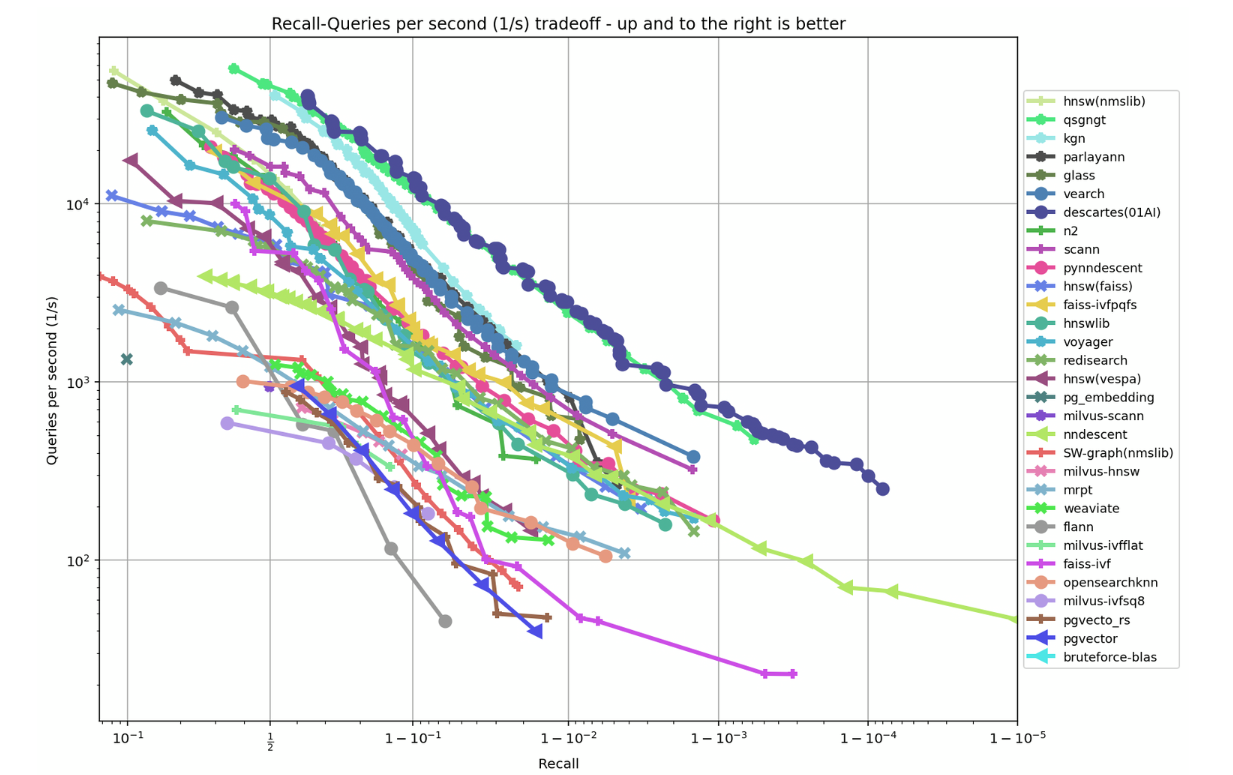

Penggunaan Repository ann benchmark memerlukan docker agar dapat dijalankan dengan baik. sayangnya Google Colab belum dilengkapi dengan docker, sehingga kita akan mencoba memvisualisasikan dengan grafik sederhana saja yang akan memberikan hasil yang mirip dengan ann benchmark.

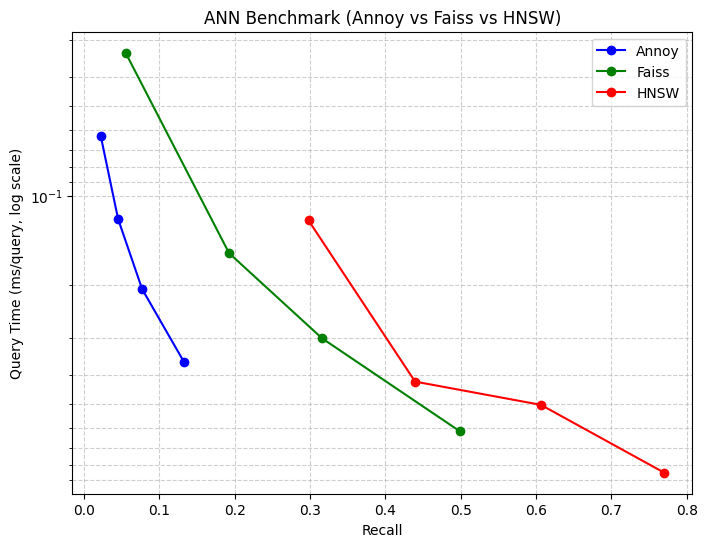

In [12]:
import numpy as np
import time
import faiss
from annoy import AnnoyIndex
import hnswlib
import matplotlib.pyplot as plt

# -------------------------------
# Dataset random
# -------------------------------
d = 128        # dimensi
nb = 100000    # jumlah database vector
nq = 1000      # jumlah query

np.random.seed(42)
xb = np.random.random((nb, d)).astype('float32')
xq = np.random.random((nq, d)).astype('float32')

# -------------------------------
# Ground truth dengan FAISS brute force
# -------------------------------
index_flat = faiss.IndexFlatL2(d)
index_flat.add(xb)
k = 10
_, gt_idx = index_flat.search(xq, k)

# -------------------------------
# Fungsi recall
# -------------------------------
def recall_at_k(I_pred, I_gt, k):
    correct = 0
    for i in range(len(I_pred)):
        correct += len(set(I_pred[i][:k]) & set(I_gt[i][:k]))
    return correct / (len(I_pred) * k)

# -------------------------------
# Benchmark Annoy
# -------------------------------
def run_annoy(xb, xq, n_trees=10, search_k=1000, k=10):
    f = xb.shape[1]
    index = AnnoyIndex(f, 'euclidean')
    for i, v in enumerate(xb):
        index.add_item(i, v)
    index.build(n_trees)

    start = time.time()
    I = [index.get_nns_by_vector(v, k, search_k=search_k) for v in xq]
    elapsed = (time.time() - start) * 1000 / len(xq)  # ms/query
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Benchmark FAISS IVF
# -------------------------------
def run_faiss(xb, xq, nlist=100, nprobe=10, k=10):
    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
    index.train(xb)
    index.add(xb)

    index.nprobe = nprobe
    start = time.time()
    _, I = index.search(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Benchmark HNSW
# -------------------------------
def run_hnsw(xb, xq, ef=100, M=16, k=10):
    num_elements = xb.shape[0]
    p = hnswlib.Index(space='l2', dim=d)
    p.init_index(max_elements=num_elements, ef_construction=200, M=M)
    p.add_items(xb)
    p.set_ef(ef)

    start = time.time()
    I, _ = p.knn_query(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Jalankan benchmark dengan beberapa parameter
# -------------------------------
results = {"Annoy": [], "Faiss": [], "HNSW": []}

# Annoy
for sk in [200, 500, 1000, 2000]:
    rec, t = run_annoy(xb, xq, n_trees=10, search_k=sk)
    results["Annoy"].append((rec, t))

# FAISS
for npb in [1, 5, 10, 20]:
    rec, t = run_faiss(xb, xq, nlist=100, nprobe=npb)
    results["Faiss"].append((rec, t))

# HNSW
for ef in [50, 100, 200, 400]:
    rec, t = run_hnsw(xb, xq, ef=ef)
    results["HNSW"].append((rec, t))

# -------------------------------
# Visualisasi trade-off
# -------------------------------
plt.figure(figsize=(8,6))
for label, color in zip(results.keys(), ["blue","green","red"]):
    recall, qtime = zip(*results[label])
    plt.plot(recall, qtime, marker="o", label=label, color=color)

plt.xlabel("Recall")
plt.ylabel("Query Time (ms/query, log scale)")
plt.yscale("log")
plt.gca().invert_yaxis()  # invert Y, makin kanan makin turun
plt.title("ANN Benchmark (Annoy vs Faiss vs HNSW)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

### Praktikum 6
Lakukan percobaan penggunaan ANNOY, FAISS, dan HNSWLIB pada dataset sekunder berukuran besar (Micro Spotify) pada link berikut: https://www.kaggle.com/datasets/bwandowando/spotify-songs-with-attributes-and-lyrics/data . Download data dan load CSV filenya (pilih dataset yg pertama dari dua dataset). pilih hanya fitur numerik saja, dan lakukan normalisasi menggunakan StandardScaler. Lakukan pencarian track terdekat dan bandingkan hasilnya.

In [1]:
# Install dependencies if running in a new environment like Google Colab
# !pip install kagglehub hnswlib faiss-cpu annoy

import pandas as pd
import numpy as np
import time
import kagglehub
from kagglehub import KaggleDatasetAdapter

# ANN Libraries
import faiss
from annoy import AnnoyIndex
import hnswlib

# Scikit-learn for baseline and preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# --- 1. Load Dataset Directly from Kaggle Hub ---
print("Memuat dataset dari Kaggle Hub...")
try:
    # Set the path to the file you'd like to load within the dataset
    # Corrected filename based on the error output
    file_path = "spotify_songs_with_attributes_and_lyrics.csv"

    # Load the latest version of the dataset
    df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "bwandowando/spotify-songs-with-attributes-and-lyrics",
        file_path,
    )
    print("Dataset berhasil dimuat.")
    print(f"Jumlah lagu dalam dataset: {len(df)}")
except Exception as e:
    print(f"Gagal memuat dataset: {e}")
    print("Pastikan Anda telah melakukan autentikasi dengan akun Kaggle Anda.")
    # In Google Colab, you might need to upload your kaggle.json or authenticate.
    # Exit is not ideal in Colab, better to just print the error and continue
    # exit()


# --- 2. Preprocess Data ---
print("\nMelakukan preprocessing data...")
# Check if df was loaded successfully before proceeding
if 'df' in locals() and df is not None:
    # Select numerical features for similarity search
    features = ['danceability', 'energy', 'loudness', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    X = df[features].dropna().values.astype(np.float32)

    # Standardize the features for distance-based algorithms
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print(f"Data siap digunakan dengan {X_scaled.shape[0]} lagu dan {X_scaled.shape[1]} fitur.")

    k = 10  # Number of nearest neighbors to find

    # --- 3. Exact Nearest Neighbor (Brute-force Baseline) ---
    print("\n--- Menjalankan Exact NN (Scikit-learn) ---")
    start_time = time.time()
    nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
    nn.fit(X_scaled)
    # Find neighbors for all items in the dataset
    dist_exact, idx_exact = nn.kneighbors(X_scaled)
    time_exact = time.time() - start_time
    print(f"Selesai dalam {time_exact:.3f} detik")

    # --- 4. Annoy ---
    print("\n--- Menjalankan Annoy ---")
    start_time = time.time()
    f = X_scaled.shape[1]
    index_annoy = AnnoyIndex(f, 'euclidean')
    for i, v in enumerate(X_scaled):
        index_annoy.add_item(i, v)
    index_annoy.build(20) # More trees for better accuracy
    # Find neighbors for all items by iterating
    idx_annoy = [index_annoy.get_nns_by_vector(v, k) for v in X_scaled]
    time_annoy = time.time() - start_time
    print(f"Selesai dalam {time_annoy:.3f} detik")

    # --- 5. HNSW (hnswlib) ---
    print("\n--- Menjalankan HNSW (hnswlib) ---")
    start_time = time.time()
    p_hnsw = hnswlib.Index(space='l2', dim=X_scaled.shape[1])
    p_hnsw.init_index(max_elements=X_scaled.shape[0], ef_construction=200, M=16)
    p_hnsw.add_items(X_scaled)
    p_hnsw.set_ef(200) # Higher ef for better accuracy
    # Find neighbors for all items at once
    idx_hnsw, dist_hnsw = p_hnsw.knn_query(X_scaled, k=k)
    time_hnsw = time.time() - start_time
    print(f"Selesai dalam {time_hnsw:.3f} detik")

    # --- 6. FAISS (IVFFlat) ---
    print("\n--- Menjalankan FAISS (IVFFlat) ---")
    start_time = time.time()
    quantizer = faiss.IndexFlatL2(X_scaled.shape[1])
    nlist = 100 # Number of clusters
    index_faiss = faiss.IndexIVFFlat(quantizer, X_scaled.shape[1], nlist, faiss.METRIC_L2)
    index_faiss.train(X_scaled)
    index_faiss.add(X_scaled)
    index_faiss.nprobe = 10 # Search in 10 nearest clusters
    # Find neighbors for all items at once
    dist_faiss, idx_faiss = index_faiss.search(X_scaled, k)
    time_faiss = time.time() - start_time
    print(f"Selesai dalam {time_faiss:.3f} detik")

    # --- 7. Final Results Comparison ---
    print("\n==============================================")
    print("              Ringkasan Waktu Proses")
    print("==============================================")
    print(f"Exact NN (Brute-force): {time_exact:>7.3f} detik")
    print(f"Annoy                 : {time_annoy:>7.3f} detik")
    print(f"HNSW (hnswlib)        : {time_hnsw:>7.3f} detik")
    print(f"FAISS (IVFFlat)       : {time_faiss:>7.3f} detik")
    print("==============================================")


    print("\nContoh perbandingan top-5 tetangga terdekat untuk lagu pertama:")
    # Ensure df is not empty before accessing iloc
    if not df.empty:
        first_song_title = df['track_name'].iloc[0]
        print(f"Lagu: '{first_song_title}'")
        print(f"Exact NN: {idx_exact[0][:5]}")
        print(f"Annoy:    {idx_annoy[0][:5]}")
        print(f"HNSW:     {idx_hnsw[0][:5]}")
        print(f"FAISS:    {idx_faiss[0][:5]}")
    else:
        print("DataFrame is empty, cannot display song title and neighbors.")

else:
    print("DataFrame was not loaded successfully. Cannot proceed with preprocessing and analysis.")

Memuat dataset dari Kaggle Hub...


/tmp/ipython-input-2544603375.py:27: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'spotify-songs-with-attributes-and-lyrics' dataset.
Gagal memuat dataset: 'spotify_songs_with_attributes_and_lyrics.csv' is not present in the dataset files. You can access the other files of the attached dataset at '/kaggle/input/spotify-songs-with-attributes-and-lyrics'
Pastikan Anda telah melakukan autentikasi dengan akun Kaggle Anda.

Melakukan preprocessing data...
DataFrame was not loaded successfully. Cannot proceed with preprocessing and analysis.


Tugas
Jalankan code berikut pada Google Colab dan PyDroid3 (Android Python) Application di Smartphone Android. Bandingkan hasilnya dan tuliskan analisa anda, tuliskan juga spesifikasi smartphone yang anda gunakan :).

In [ ]:
import numpy as np
import time
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
import hnswlib
import faiss
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Contoh dataset kecil untuk testing
# -------------------------------
np.random.seed(42)
n_samples = 10000   # jumlah database vector
d = 128             # dimensi
X = np.random.random((n_samples, d)).astype('float32')

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 10  # jumlah nearest neighbors

# -------------------------------
# Exact NN (brute-force)
# -------------------------------
start = time.time()
nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
nn.fit(X_scaled)
dist_exact, idx_exact = nn.kneighbors(X_scaled)
time_exact = time.time() - start
print(f"Exact NN done in {time_exact:.3f} s")

# -------------------------------
# Annoy
# -------------------------------
start = time.time()
f = X_scaled.shape[1]
index_annoy = AnnoyIndex(f, 'euclidean')
for i, v in enumerate(X_scaled):
    index_annoy.add_item(i, v)
index_annoy.build(10)
idx_annoy = [index_annoy.get_nns_by_vector(v, k) for v in X_scaled]
time_annoy = time.time() - start
print(f"Annoy done in {time_annoy:.3f} s")

# -------------------------------
# HNSW
# -------------------------------
start = time.time()
p_hnsw = hnswlib.Index(space='l2', dim=d)
p_hnsw.init_index(max_elements=n_samples, ef_construction=200, M=16)
p_hnsw.add_items(X_scaled)
p_hnsw.set_ef(200)
idx_hnsw, _ = p_hnsw.knn_query(X_scaled, k=k)
time_hnsw = time.time() - start
print(f"HNSW done in {time_hnsw:.3f} s")

# -------------------------------
# FAISS IVF
# -------------------------------
start = time.time()
quantizer = faiss.IndexFlatL2(d)
index_faiss = faiss.IndexIVFFlat(quantizer, d, nlist=100, metric=faiss.METRIC_L2)
index_faiss.train(X_scaled)
index_faiss.add(X_scaled)
index_faiss.nprobe = 10
_, idx_faiss = index_faiss.search(X_scaled, k)
time_faiss = time.time() - start
print(f"FAISS IVF done in {time_faiss:.3f} s")

# -------------------------------
# Tampilkan ringkasan waktu
# -------------------------------
print("\n=== Ringkasan Waktu (detik) ===")
print(f"Exact NN : {time_exact:.3f}")
print(f"Annoy    : {time_annoy:.3f}")
print(f"HNSW     : {time_hnsw:.3f}")
print(f"FAISS    : {time_faiss:.3f}")
